In [1]:
# conda activate movie-recommender          # activate environment in terminal         


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
chunksize=100000
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:


# movies
all_movies = pd.DataFrame()  # initialize an empty dataframe
for index, chunk in enumerate(pd.read_csv('../ml-20m/movies.csv',
                         dtype={'movieId': str, 'title': str, "genres": str},
                         chunksize=chunksize,
                         )):
    # Perform operations on the chunk
    # processed_chunk = chunk[chunk['column_name'] > 0]  # Example operation
    all_movies = pd.concat([all_movies, chunk])
    print(f"Chunk {index} loaded")
print("movies dataset loaded")

Chunk 0 loaded
movies dataset loaded


In [4]:
# Custom date parser function
date_parser = lambda x: pd.to_datetime(x, unit='s')

# movies
ratings_exploration_csv = pd.DataFrame()  # initialize an empty dataframe
for index, chunk in enumerate(pd.read_csv('../samples/ratings_univariate_end_sample.csv',
                                          dtype={ 'movieId': str,},
                         chunksize=chunksize,
                         )):
    # Perform operations on the chunk
    # processed_chunk = chunk[chunk['column_name'] > 0]  # Example operation
    ratings_exploration_csv = pd.concat([ratings_exploration_csv, chunk])
    print(f"Chunk {index} loaded")
print("ratings dataset loaded")

Chunk 0 loaded
Chunk 1 loaded
Chunk 2 loaded
Chunk 3 loaded
Chunk 4 loaded
Chunk 5 loaded
Chunk 6 loaded
Chunk 7 loaded
Chunk 8 loaded
Chunk 9 loaded
Chunk 10 loaded
Chunk 11 loaded
Chunk 12 loaded
Chunk 13 loaded
Chunk 14 loaded
ratings dataset loaded


In [5]:
all_movies.info()
all_movies.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  object
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: object(3)
memory usage: 639.5+ KB


movieId    27278
title      27262
genres      1342
dtype: int64

In [6]:
ratings_exploration_csv.nunique()

userId         13849
movieId        15316
rating             5
timestamp    1052704
year              21
month             12
season             4
dtype: int64

Next, I will create a new DataFrame from the movies dataset that only includes movies with the same movieIds as those in the dataset created in the rating exploration file

In [7]:

movie_ids_to_keep = ratings_exploration_csv['movieId']

# Filter the movies DataFrame to only include movies with movieIds in movie_ids_to_keep
movies = all_movies[all_movies['movieId'].isin(movie_ids_to_keep)]

movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15316 entries, 0 to 27254
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  15316 non-null  object
 1   title    15316 non-null  object
 2   genres   15316 non-null  object
dtypes: object(3)
memory usage: 478.6+ KB


I have created a new dataframe based on the ids from the ratings exploration file. Next I will transform the data, into a more usable form

In [8]:

# extract name and year from the title column
movies[['movie_name', 'movie_year']] = movies['title'].str.extract(r'^(.*) \((\d{4})\)$')


movies.head(10)


/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_6943/1295891466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[['movie_name', 'movie_year']] = movies['title'].str.extract(r'^(.*) \((\d{4})\)$')
/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_6943/1295891466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[['movie_name', 'movie_year']] = movies['title'].str.extract(r'^(.*) \((\d{4})\)$')


,movieId,title,genres,movie_name,movie_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995
5,6,Heat (1995),Action|Crime|Thriller,Heat,1995
6,7,Sabrina (1995),Comedy|Romance,Sabrina,1995
7,8,Tom and Huck (1995),Adventure|Children,Tom and Huck,1995
8,9,Sudden Death (1995),Action,Sudden Death,1995
9,10,GoldenEye (1995),Action|Adventure|Thriller,GoldenEye,1995


next, the genre column will be transformed. Currently, the genres are all in one column seperated by a pipe symbol

In [9]:
movies["genres"].nunique()

1077

there are 1077 unique strings of genre combinations. Next, every row in the dataset will include a column for each genre in the entire dataset. If the genre applies, the correlating column will be assigned the value of true otherwise false

In [10]:
movies['genres_list'] = movies['genres'].str.split('|')
genres_one_hot_list = movies['genres_list'].explode().str.get_dummies()
genres_one_hot = genres_one_hot_list.groupby(level=0).sum().astype(bool)
movies = pd.concat([movies, genres_one_hot], axis=1)

movies.drop(columns=['genres_list'], inplace=True)
movies.head(10)

/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_6943/997123409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres_list'] = movies['genres'].str.split('|')


,movieId,title,genres,movie_name,movie_year,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,6,Heat (1995),Action|Crime|Thriller,Heat,1995,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,7,Sabrina (1995),Comedy|Romance,Sabrina,1995,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
7,8,Tom and Huck (1995),Adventure|Children,Tom and Huck,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
8,9,Sudden Death (1995),Action,Sudden Death,1995,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,10,GoldenEye (1995),Action|Adventure|Thriller,GoldenEye,1995,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False


Next, we can perform analyses of the dataset. First lets look at the "year" column

In [11]:

movies = movies.dropna(subset=['movie_year'])
movies['movie_year'] = movies['movie_year'].astype(int)
print(movies['movie_year'].describe())
print(movies['movie_year'].nunique())

count    15272.000000
mean      1990.466606
std         20.735672
min       1893.000000
25%       1981.000000
50%       1997.000000
75%       2006.000000
max       2015.000000
Name: movie_year, dtype: float64
112


The earliest movie is from the year 1893, while the newest movie is 2015 - the same year as the dataset was published. The average year is 1990, whereas the median year is 1997.  

In [12]:
movies['movie_year'].hist(bins=40)
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

Text(0, 0.5, 'Number of Movies')

Seems to show a gradual increase in movies closer to present time. This is likly due to there being more movies created in this time.

Next, the genres will be explored

/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_6943/390982461.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values,  palette="hls")


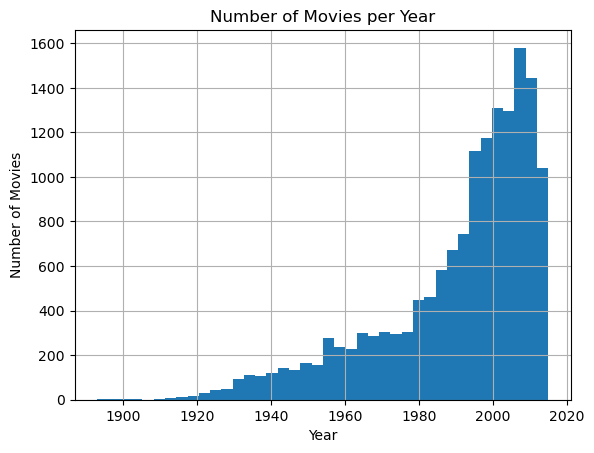

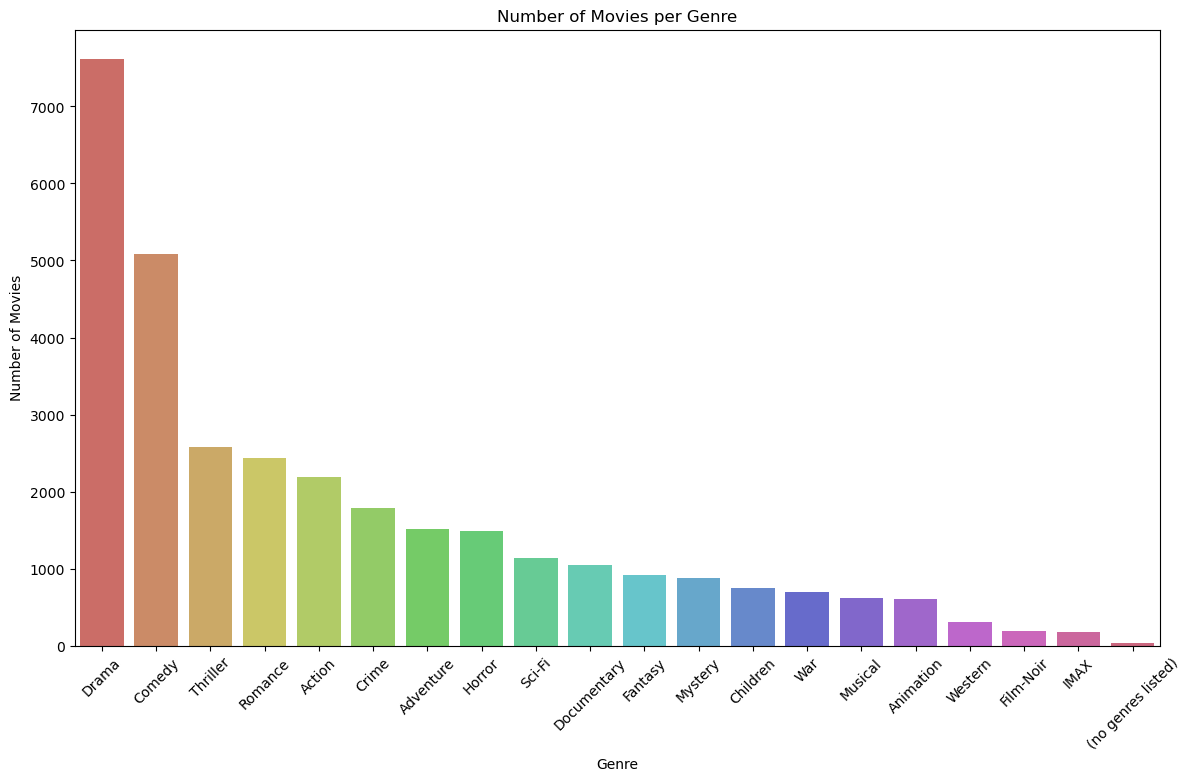

In [13]:
genre_counts = genres_one_hot.sum().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.color_palette("hls", 8)
sns.barplot(x=genre_counts.index, y=genre_counts.values,  palette="hls")
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [14]:
print(genre_counts)

Drama                 7616
Comedy                5081
Thriller              2584
Romance               2432
Action                2183
Crime                 1781
Adventure             1513
Horror                1493
Sci-Fi                1143
Documentary           1044
Fantasy                916
Mystery                874
Children               748
War                    697
Musical                622
Animation              605
Western                309
Film-Noir              189
IMAX                   175
(no genres listed)      35
dtype: int64


This chart shows the most rated genre is drama, followed by Comedy. Other genres are less high. Next lets look at how each genre is represented acorss the years. 

In [15]:
genres_1 = genre_counts.iloc[0:5]
genres_2 = genre_counts.iloc[5:10]
genres_3 = genre_counts.iloc[10:15]
genres_4 = genre_counts.iloc[15:20]

<Figure size 1400x800 with 0 Axes>

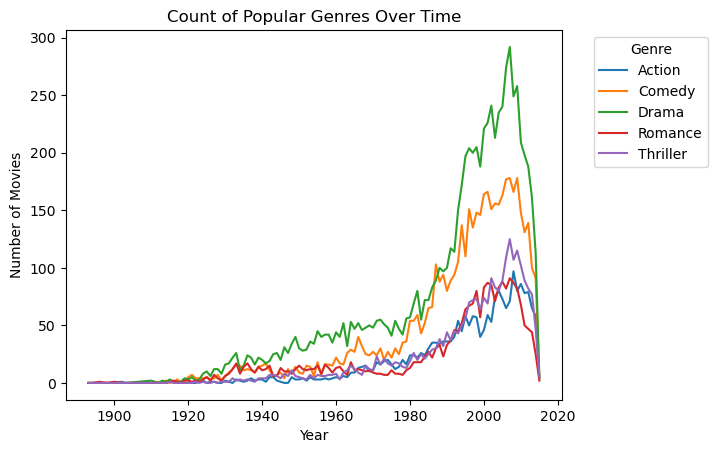

In [16]:
genre_1_year_counts = movies.drop(columns=genre_counts.iloc[5:20].index).groupby(['movie_year']).sum()

# Plot the count of each genre per year
plt.figure(figsize=(14, 8))
genre_1_year_counts.plot(kind='line', stacked=False)
plt.title('Count of Popular Genres Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 1400x800 with 0 Axes>

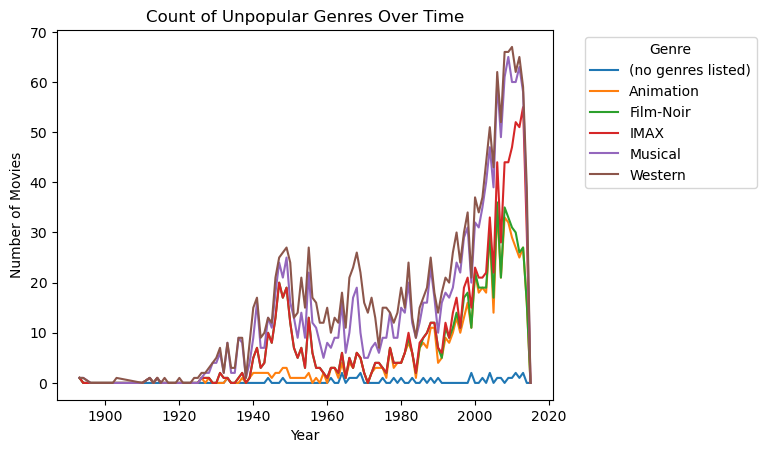

In [17]:

unpopular_genre_year_counts = movies.drop(columns=genre_counts.iloc[0:14].index).groupby(['movie_year']).sum()

# Plot the count of each genre per year
plt.figure(figsize=(14, 8))
unpopular_genre_year_counts.plot(kind='line', stacked=True)
plt.title('Count of Unpopular Genres Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Next I will combine the movies and ratings datasets into one csv

In [18]:
ratings_exploration_csv = ratings_exploration_csv.rename(columns={
    'rating': 'user_rating',
    'year': 'rating_year',
    'month': 'rating_month',
    'season': 'rating_season',
    'timestamp': 'rating_timestamp'
})

# Merge the movies dataset with the ratings dataset on 'movieId'
combined_df = pd.merge(movies, ratings_exploration_csv, on='movieId', how='inner')

# Export the combined dataset to a CSV file
combined_df.to_csv('../samples/combined_movies_ratings.csv', index=False)